In [66]:
import copy
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from os.path import join as oj
from tqdm import tqdm

from imodels.importance import R2FExp, GeneralizedMDI, GeneralizedMDIJoint
from imodels.importance import LassoScorer, RidgeScorer, ElasticNetScorer, RobustScorer, LogisticScorer, JointRidgeScorer, JointLogisticScorer, JointRobustScorer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import permutation_importance
import shap

import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
DATA_DIR = "../../data"

In [3]:
X_df = pd.read_csv(oj(DATA_DIR, "X_tcga_var_filtered_log_transformed.csv"))
X = X_df.to_numpy()
y = pd.read_csv(oj(DATA_DIR, "Y_tcga.csv")).to_numpy().ravel()

In [4]:
X_df.head()

A2M      NAT1  RP11.986E7.7      AAMP      AARS      ABAT     ABCA2  \
0  9.614527  7.401763     10.859011  7.765291  7.625208  7.715826  7.500286   
1  8.725323  9.375599     10.128432  7.388699  7.658290  7.463426  7.031804   
2  8.671585  7.756825     10.690369  8.064953  7.976935  8.461162  7.444768   
3  9.339170  6.155162      7.340154  7.815608  8.993226  6.216886  6.922385   
4  8.909420  4.402246      8.196574  8.366875  7.949886  5.881482  8.076330   

      ABCA3     ABCF1      ABL1  ...  EIF3CL.1     PLIN4      MTPN     RELL1  \
0  6.677448  7.228231  7.572464  ...  9.237782  5.359995  8.073793  6.500534   
1  8.702240  7.566244  7.363025  ...  9.349586  6.583817  8.185900  6.551568   
2  8.378548  7.731562  7.365497  ...  9.417242  4.251032  8.359054  7.816944   
3  7.906770  8.111439  7.358005  ...  9.887913  4.239956  8.562925  7.082101   
4  7.432998  7.809034  7.864155  ...  9.525658  5.304333  8.157452  6.425711   

    SNHG8.1      OST4     TSTD1  GAGE12J.4    NBPF10  PRICKLE4.1  
0  6.411474  7.729637  7.369472   0.000000  6.609727    7.551117  
1  3.425952  7.161099  7.052134   0.000000  7.665767    7.310317  
2  5.631785  7.984734  7.587183   0.309101  6.425312    7.941761  
3  7.108862  7.414290  5.987086   0.000000  7.137403    7.841682  
4  6.033721  8.060675  7.341724   0.000000  6.776412    7.650708  

[5 rows x 5000 columns]

In [5]:
y

array(['LumA', 'LumB', 'LumA', ..., 'LumA', 'LumA', 'LumA'], dtype=object)

In [6]:
X.shape, y.shape

((1083, 5000), (1083,))

## gjMDI Ridge

In [30]:
%%time
rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_features="sqrt")
scorer = JointRidgeScorer(criterion="gcv", metric="loocv")
gjMDI_obj = GeneralizedMDIJoint(rf_model, scorer=scorer, normalize_raw=True, random_state=331)
imp_values, scores, class_scores, n_stumps, n_stumps_chosen = gjMDI_obj.get_importance_scores(X, y, diagnostics=True)

CPU times: user 2min 52s, sys: 22.7 s, total: 3min 14s
Wall time: 1min 26s


In [31]:
pd.DataFrame({"feature": X_df.columns, "importance": imp_values}).sort_values("importance", ascending=False)

feature  importance
626     ESR1    0.018081
2984   KIF2C    0.010752
296     CDK1    0.008960
885    FOXA1    0.008457
4798    AGR3    0.008108
...      ...         ...
642    FABP4   -0.002157
2666   AP1M2   -0.002173
130     ARL1   -0.002771
4883   FDCSP   -0.003144
660   EFEMP1   -0.003203

[5000 rows x 2 columns]

In [17]:
%%time
rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_features="sqrt")
scorer = JointRidgeScorer(criterion="gcv", metric="loocv")
gjMDI_obj = GeneralizedMDIJoint(rf_model, scorer=scorer, normalize_raw=True, random_state=331)
imp_values, scores, class_scores_dict, n_stumps, n_stumps_chosen = gjMDI_obj.get_importance_scores(X, y, diagnostics=True)

CPU times: user 2min 41s, sys: 15.7 s, total: 2min 57s
Wall time: 59.5 s


In [18]:
pd.DataFrame({"feature": X_df.columns, "importance": imp_values}).sort_values("importance", ascending=False)

feature  importance
626      ESR1    0.016608
1234    MYBL2    0.010867
4289     MLPH    0.010359
688     FOXM1    0.009905
296      CDK1    0.009805
...       ...         ...
4093  ZNF512B   -0.002143
175     KIF1A   -0.002162
2855  SLC34A2   -0.002209
4170     NTN4   -0.002237
4746     SELM   -0.004569

[5000 rows x 2 columns]

In [32]:
scores.shape

(100, 5000)

In [33]:
class_scores.shape

(500000, 7)

In [34]:
class_scores.head()

tree  feature  Basal  Her2  LumA  LumB  Normal
0     0        0    0.0   0.0   0.0   0.0     0.0
1     0        1    0.0   0.0   0.0   0.0     0.0
2     0        2    0.0   0.0   0.0   0.0     0.0
3     0        3    0.0   0.0   0.0   0.0     0.0
4     0        4    0.0   0.0   0.0   0.0     0.0

In [35]:
mean_class_scores = class_scores.groupby("feature").agg("mean")
mean_class_scores.head()

tree     Basal      Her2      LumA      LumB    Normal
feature                                                        
0        49.5 -0.000151 -0.000202  0.000003 -0.000161 -0.000022
1        49.5  0.007012  0.000139  0.008300  0.000362 -0.000362
2        49.5 -0.000118  0.000370  0.000400 -0.000054 -0.000099
3        49.5 -0.000030 -0.000071 -0.000005 -0.000060 -0.000076
4        49.5 -0.000026 -0.000378  0.001299 -0.000194 -0.000494

In [37]:
for class_idx, class_label in enumerate(gjMDI_obj.estimator.classes_):
    print(pd.DataFrame({"feature": X_df.columns, class_label: mean_class_scores[class_label]}).sort_values(class_label, ascending=False).reset_index(drop=True))

       feature     Basal
0        FOXA1  0.031686
1         ESR1  0.019318
2        FOXC1  0.016664
3     FAM171A1  0.015775
4         XBP1  0.011666
...        ...       ...
4995     TRPA1 -0.003874
4996    EEF1A1 -0.004045
4997      ARL1 -0.005340
4998    EFEMP1 -0.005819
4999     FDCSP -0.006814

[5000 rows x 2 columns]
     feature      Her2
0       ESR1  0.005421
1      ERBB2  0.003272
2       GRB7  0.002640
3      MIEN1  0.002163
4     STARD3  0.001870
...      ...       ...
4995   AP1M2 -0.007787
4996  TPSAB1 -0.008001
4997    ARL1 -0.008683
4998  EFEMP1 -0.009941
4999   FDCSP -0.009971

[5000 rows x 2 columns]
     feature      LumA
0       ESR1  0.023726
1      KIF2C  0.018336
2      KPNA2  0.015643
3       CDK1  0.015209
4       PRC1  0.012108
...      ...       ...
4995   SFRP1 -0.000515
4996    EGFR -0.000691
4997   KRT16 -0.000821
4998     MIA -0.001122
4999   FOXC1 -0.002555

[5000 rows x 2 columns]
     feature      LumB
0       ESR1  0.009884
1       CDK1  0.005854
2   

## gjMDI Ridge with Stability Analysis

In [41]:
N_REPS = 10
METRIC = "loocv"

In [50]:
imp_values_dict = {}
class_scores_dict = {}
for rep in tqdm(range(N_REPS)):
    rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_features="sqrt",
                                      random_state=rep)
    scorer = JointRidgeScorer(criterion="gcv", metric="loocv")
    gjMDI_obj = GeneralizedMDIJoint(rf_model, scorer=scorer, normalize_raw=True, random_state=331)
    imp_values, _, class_scores, _, _ = gjMDI_obj.get_importance_scores(X, y, diagnostics=True)
    imp_values_dict[rep] = copy.deepcopy(imp_values)
    class_scores_dict[rep] = copy.deepcopy(class_scores.drop("tree", axis=1).\
                                           groupby("feature").agg("mean").reset_index())

100%|██████████| 10/10 [10:33<00:00, 63.32s/it]


In [60]:
imp_values_df = pd.DataFrame.from_dict(imp_values_dict)
imp_values_df.columns = ["rep{}".format(i) for i in range(imp_values_df.shape[1])]

In [61]:
from plotnine import ggplot, aes, geom_boxplot, geom_point, theme

In [62]:
imp_values_df.head()

rep0      rep1      rep2      rep3      rep4      rep5      rep6  \
0  0.000000  0.000026 -0.000051 -0.000006 -0.000247 -0.000135 -0.000084   
1  0.002902  0.003209  0.002389  0.001036  0.003869  0.003577  0.003569   
2  0.000178  0.000382  0.000420  0.000132  0.000701  0.000719  0.000419   
3  0.000002 -0.003678  0.000002 -0.000102 -0.000224  0.000000 -0.000622   
4  0.000002  0.000399  0.000000  0.000173  0.000215  0.000000  0.000000   

           rep7          rep8          rep9  
0 -8.783490e-06 -7.968867e-05  8.042125e-07  
1  4.404227e-03  3.742638e-03  3.552489e-03  
2  1.245684e-04  2.204837e-04  1.568222e-05  
3 -9.694346e-07  8.157607e-07 -7.528266e-04  
4  2.665904e-04  1.259227e-04  2.727978e-04

In [68]:
sns.pairplot(imp_values_df)

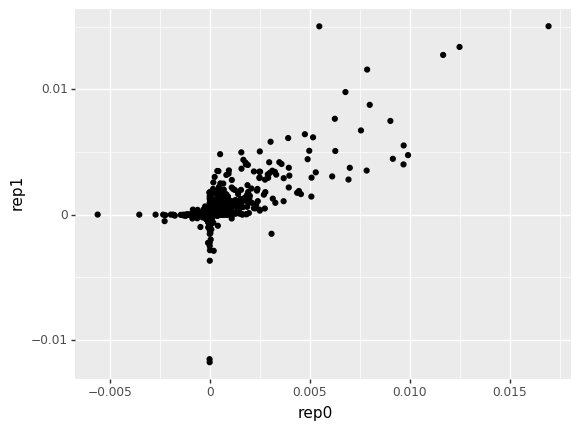

<ggplot: (8781193351285)>

In [63]:
ggplot(imp_values_df) +\
    aes(x="rep0", y="rep1") +\
    geom_point()

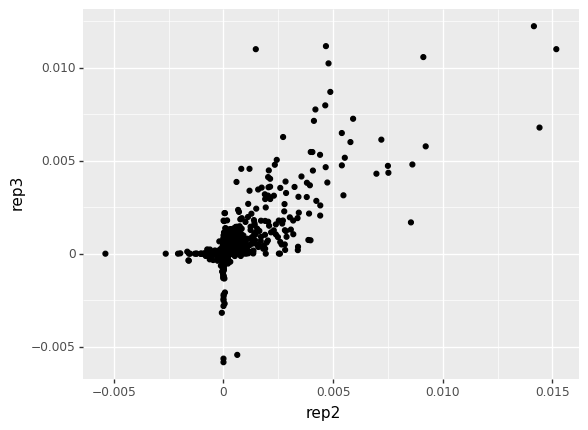

<ggplot: (8781161118109)>

In [65]:
ggplot(imp_values_df) +\
    aes(x="rep2", y="rep3") +\
    geom_point()

## Stability Analysis - gjMDI Ridge, MDI, Permutation

In [70]:
N_REPS = 10
METRIC = "loocv"

In [72]:
imp_values_dict = {}
class_scores_dict = {}
mdi_imp_values_dict = {}
perm_imp_values_dict = {}
for rep in tqdm(range(N_REPS)):
    rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_features="sqrt",
                                      random_state=rep)
    scorer = JointRidgeScorer(criterion="gcv", metric=METRIC)
    gjMDI_obj = GeneralizedMDIJoint(rf_model, scorer=scorer, normalize_raw=True, random_state=331)
    imp_values, _, class_scores, _, _ = gjMDI_obj.get_importance_scores(X, y, diagnostics=True)
    imp_values_dict[rep] = copy.deepcopy(imp_values)
    class_scores_dict[rep] = copy.deepcopy(class_scores.drop("tree", axis=1).\
                                           groupby("feature").agg("mean").reset_index())

    rf_model.fit(X, y)
    mdi_imp_values_dict[rep] = rf_model.feature_importances_

    perm_fit = permutation_importance(rf_model, X, y, n_repeats=10, random_state=0)
    perm_imp_values_dict[rep] = perm_fit.importances_mean


100%|██████████| 10/10 [7:13:21<00:00, 2600.14s/it] 


In [73]:
imp_values_df = pd.DataFrame.from_dict(imp_values_dict)
imp_values_df.columns = ["rep{}".format(i) for i in range(imp_values_df.shape[1])]
mdi_imp_values_df = pd.DataFrame.from_dict(mdi_imp_values_dict)
mdi_imp_values_df.columns = ["rep{}".format(i) for i in range(mdi_imp_values_df.shape[1])]
perm_imp_values_df = pd.DataFrame.from_dict(perm_imp_values_dict)
perm_imp_values_df.columns = ["rep{}".format(i) for i in range(perm_imp_values_df.shape[1])]

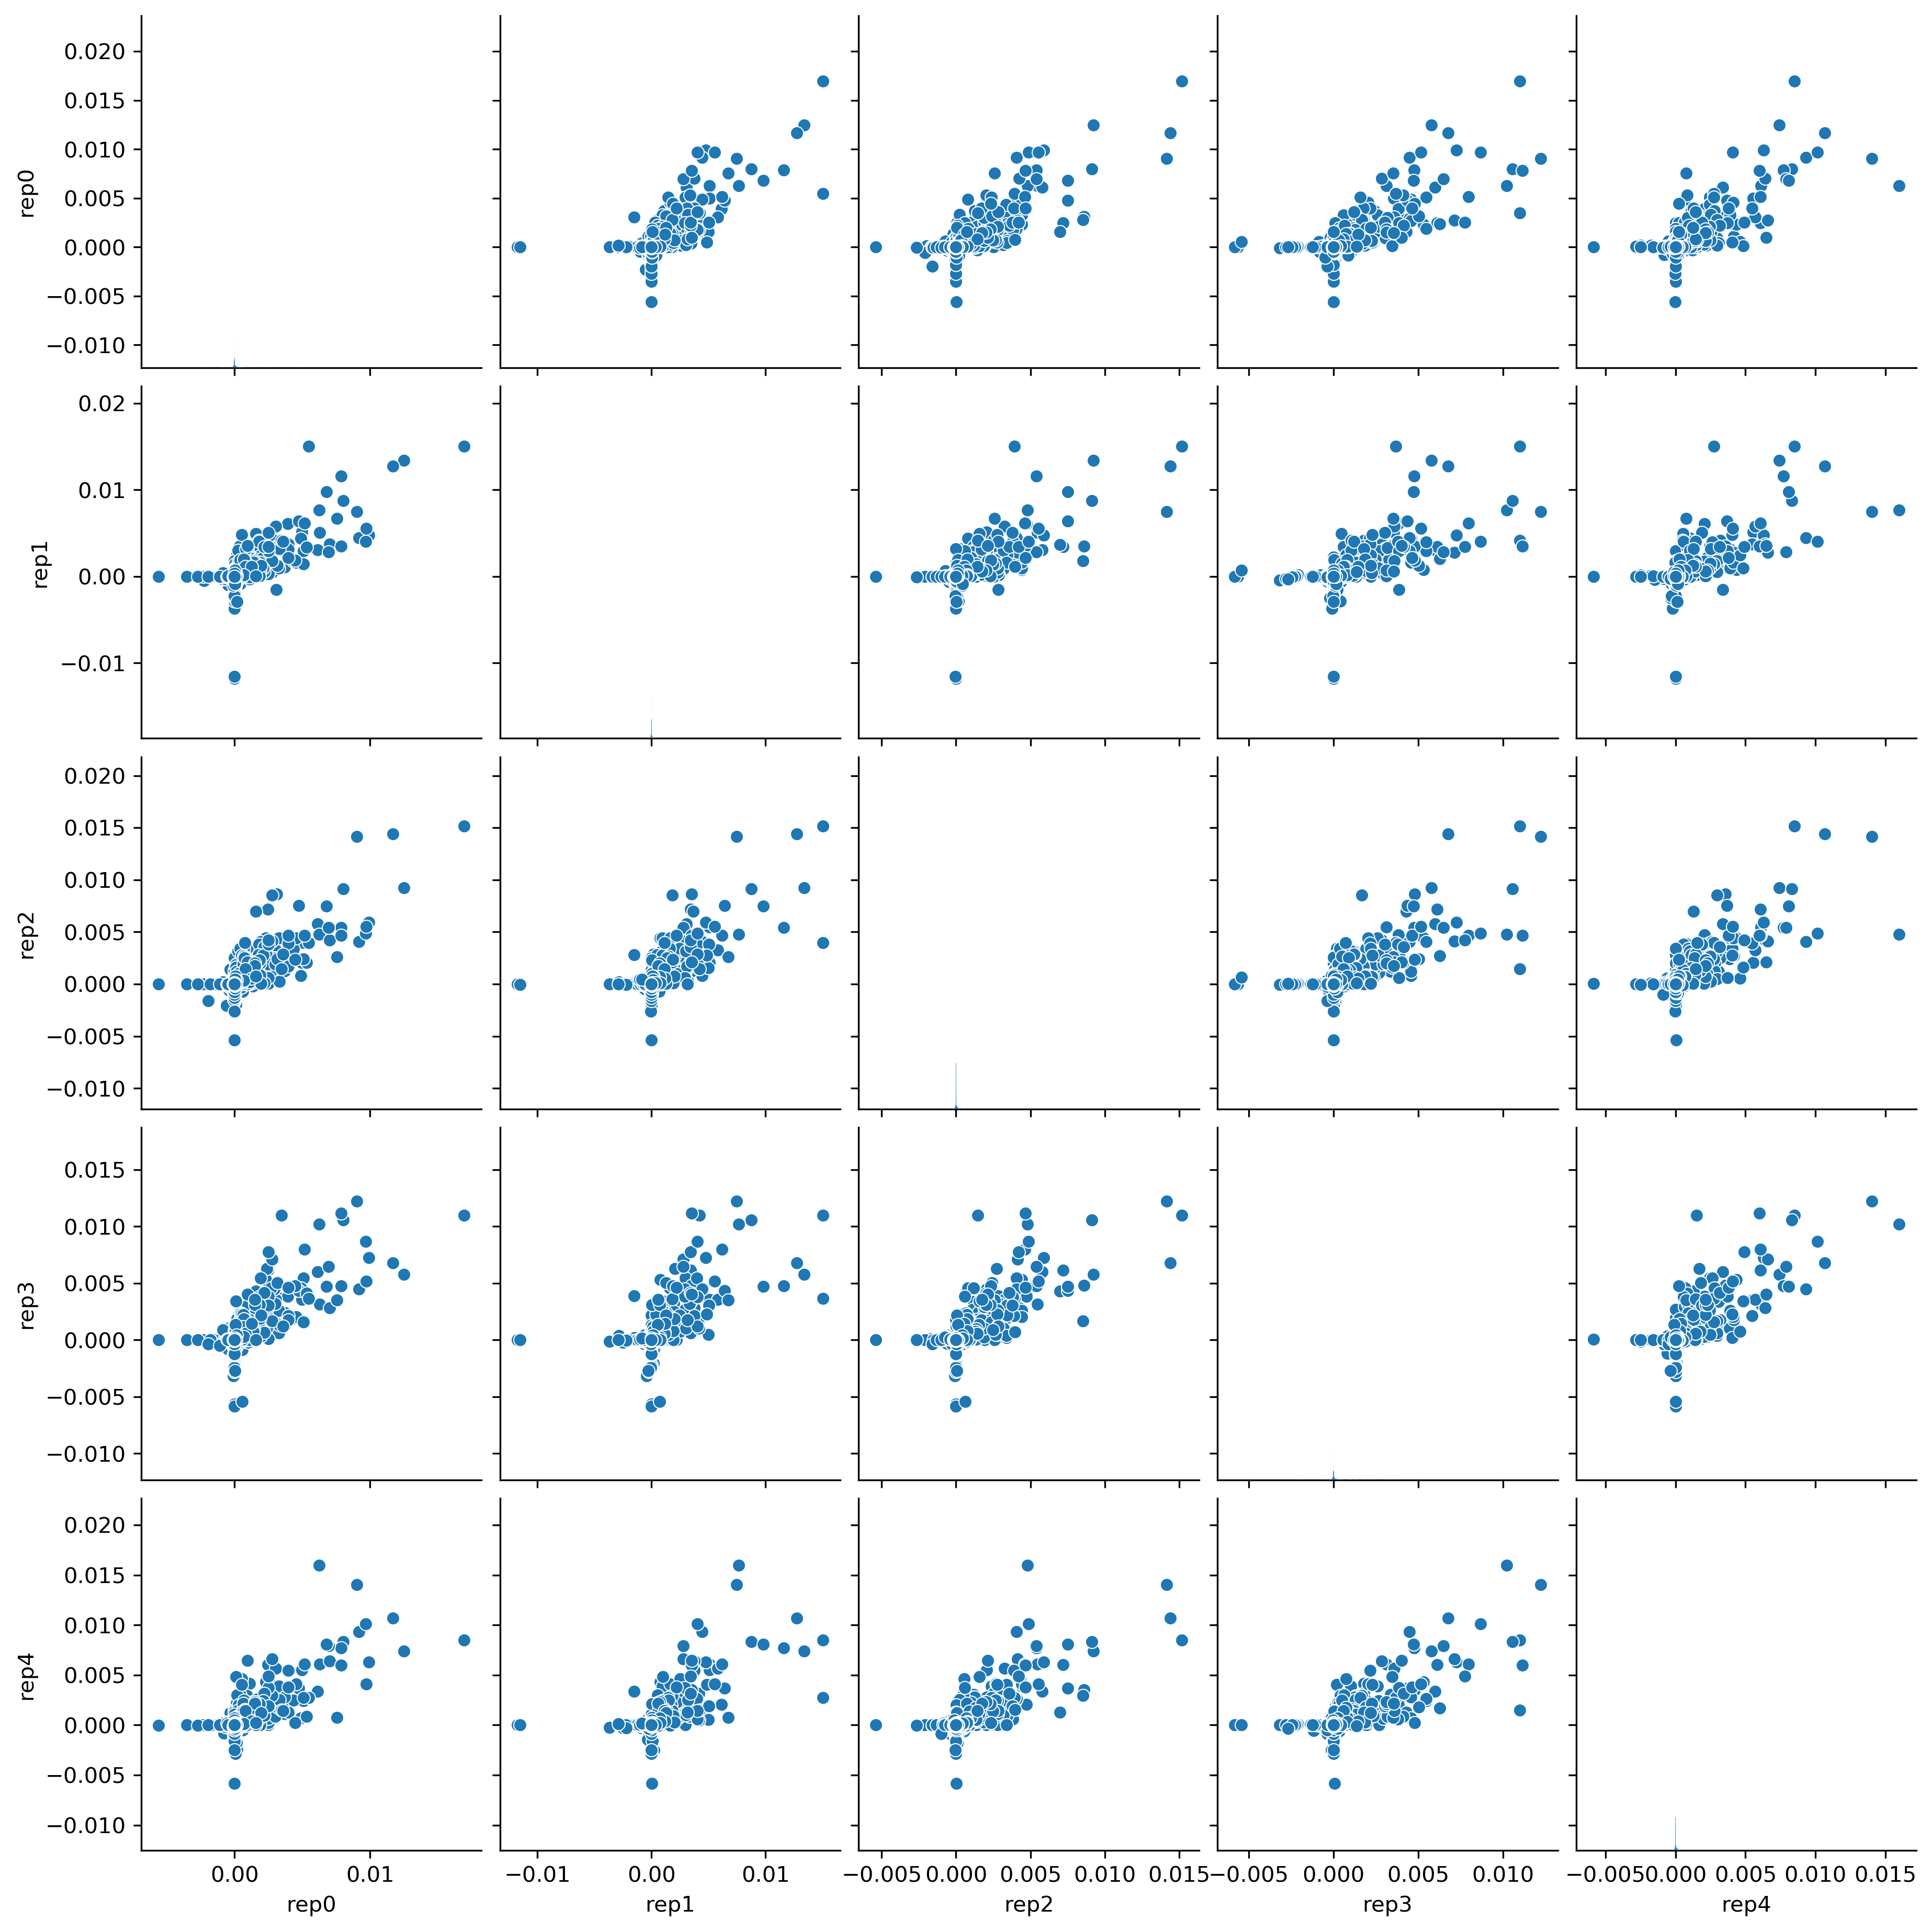

In [74]:
sns.pairplot(imp_values_df.iloc[:, :5])

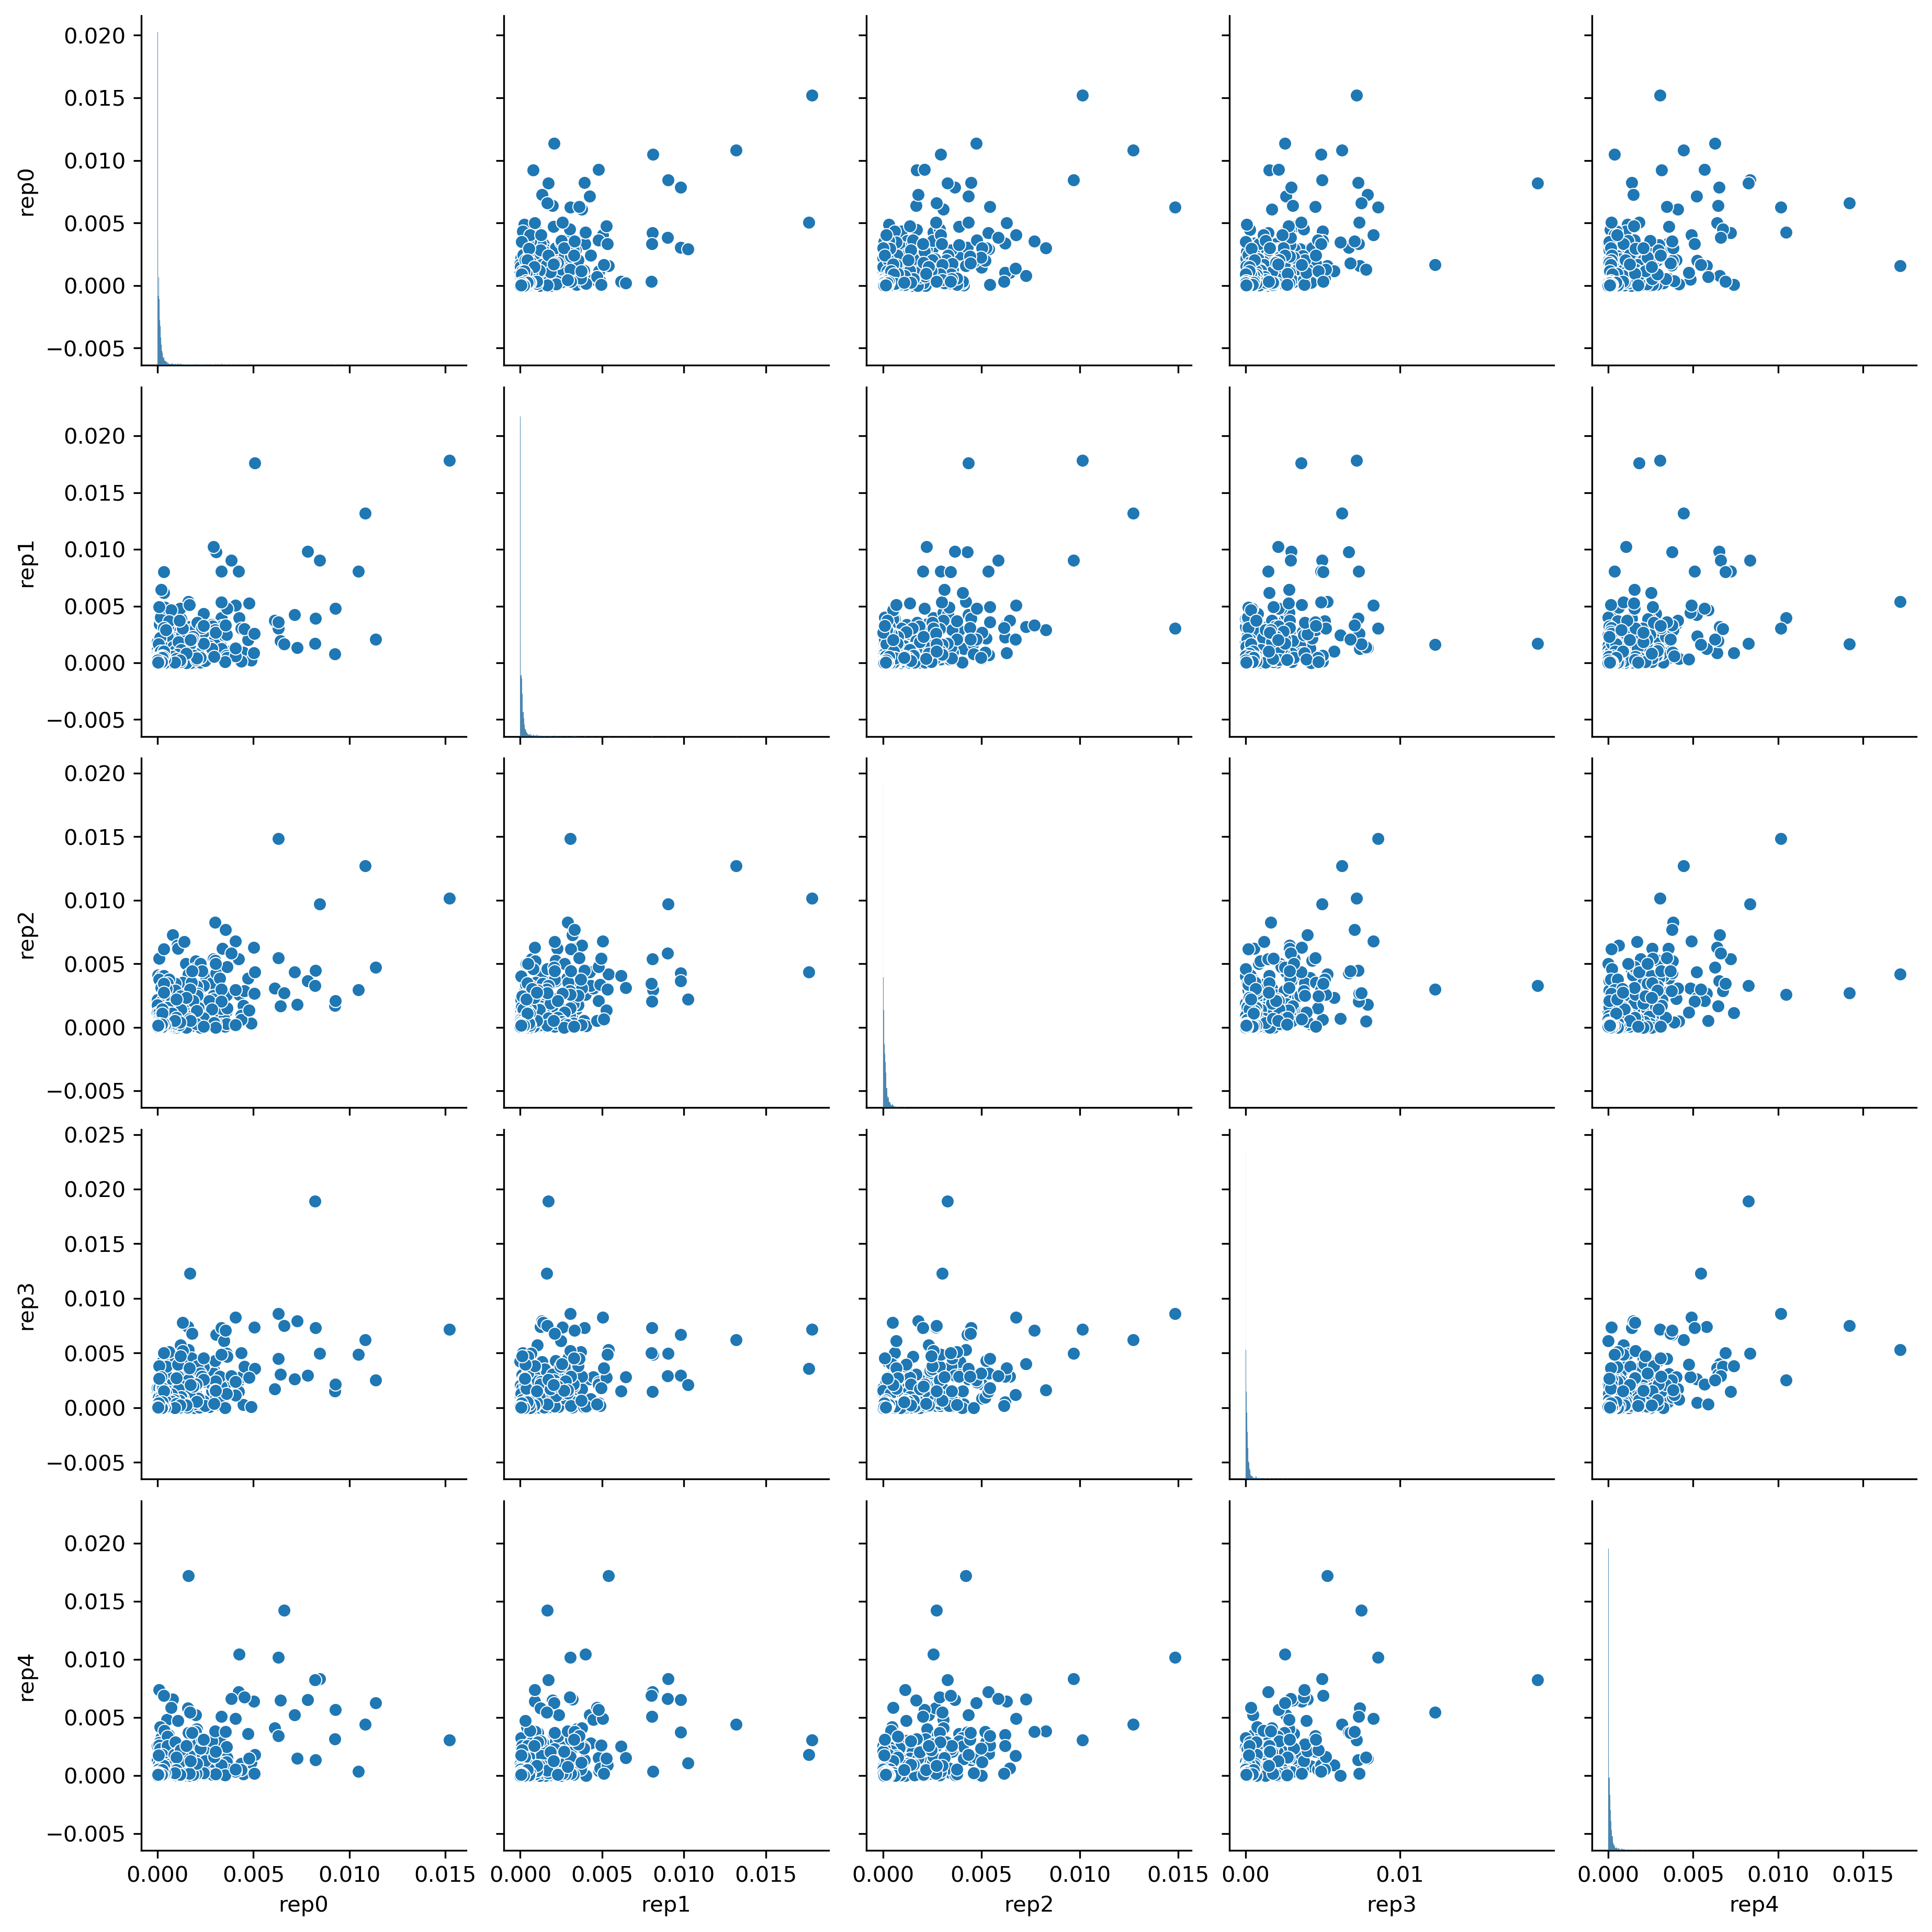

In [75]:
sns.pairplot(mdi_imp_values_df.iloc[:, :5])

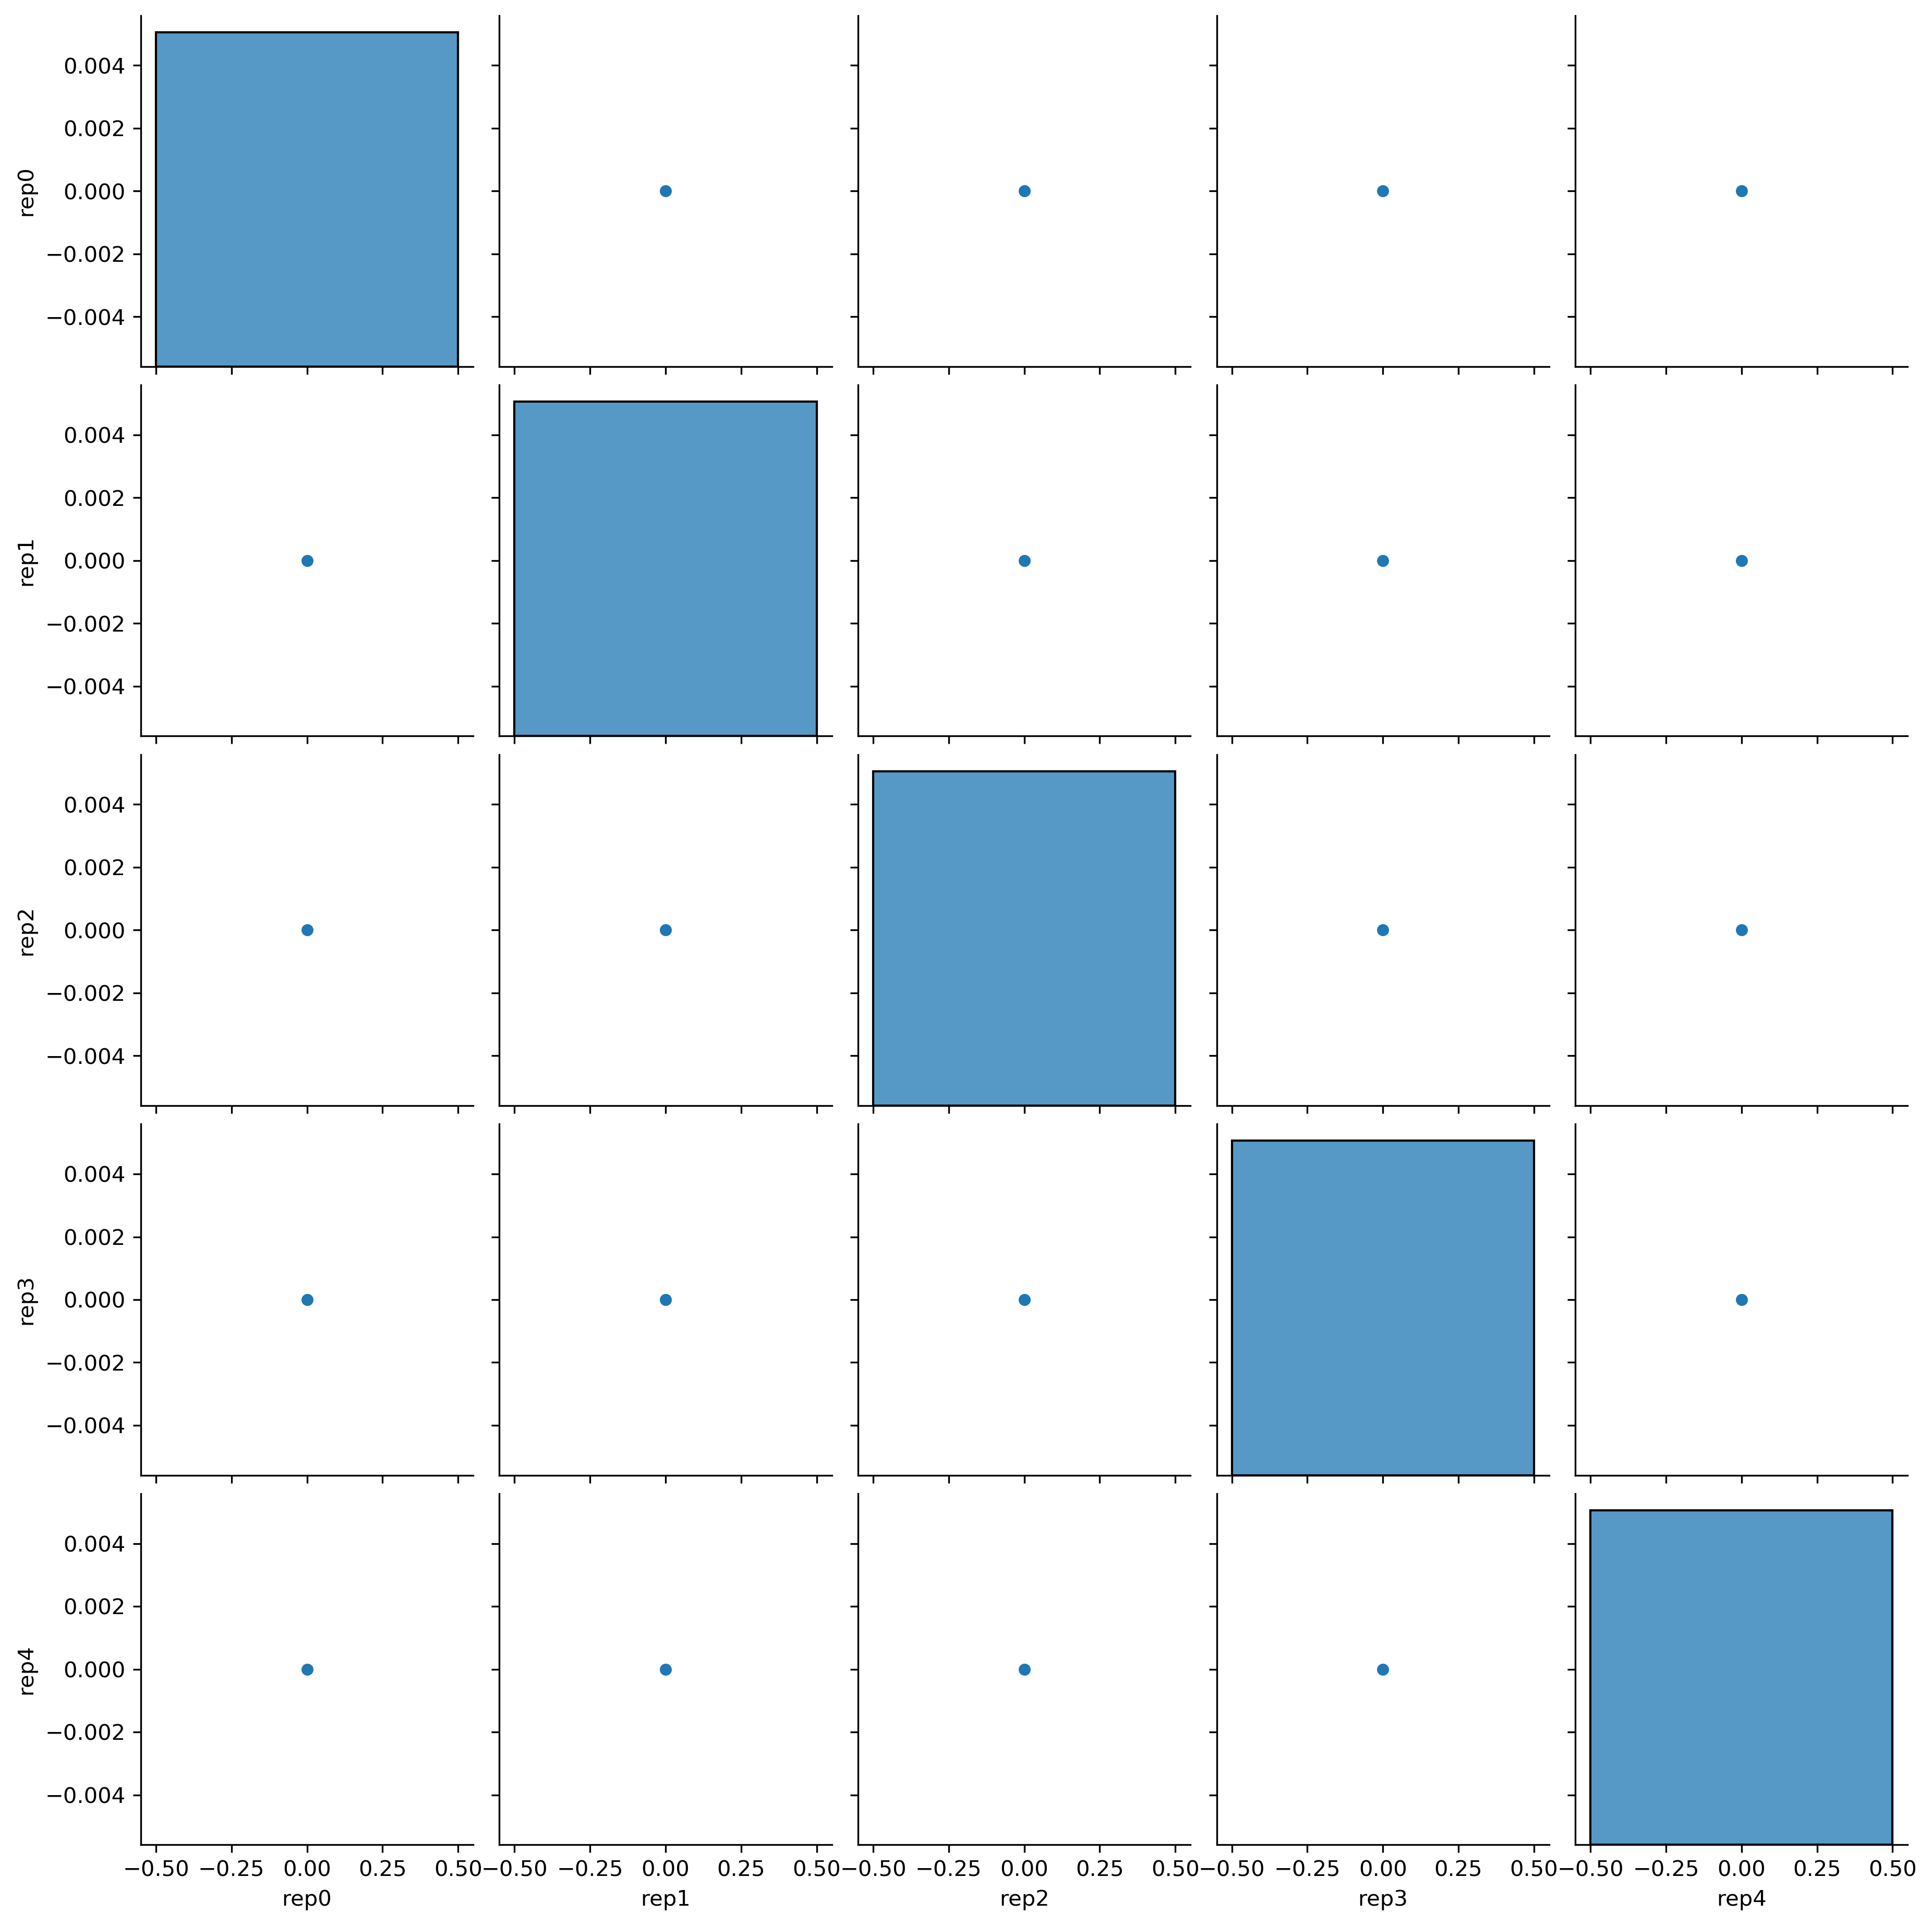

In [76]:
sns.pairplot(perm_imp_values_df.iloc[:, :5])

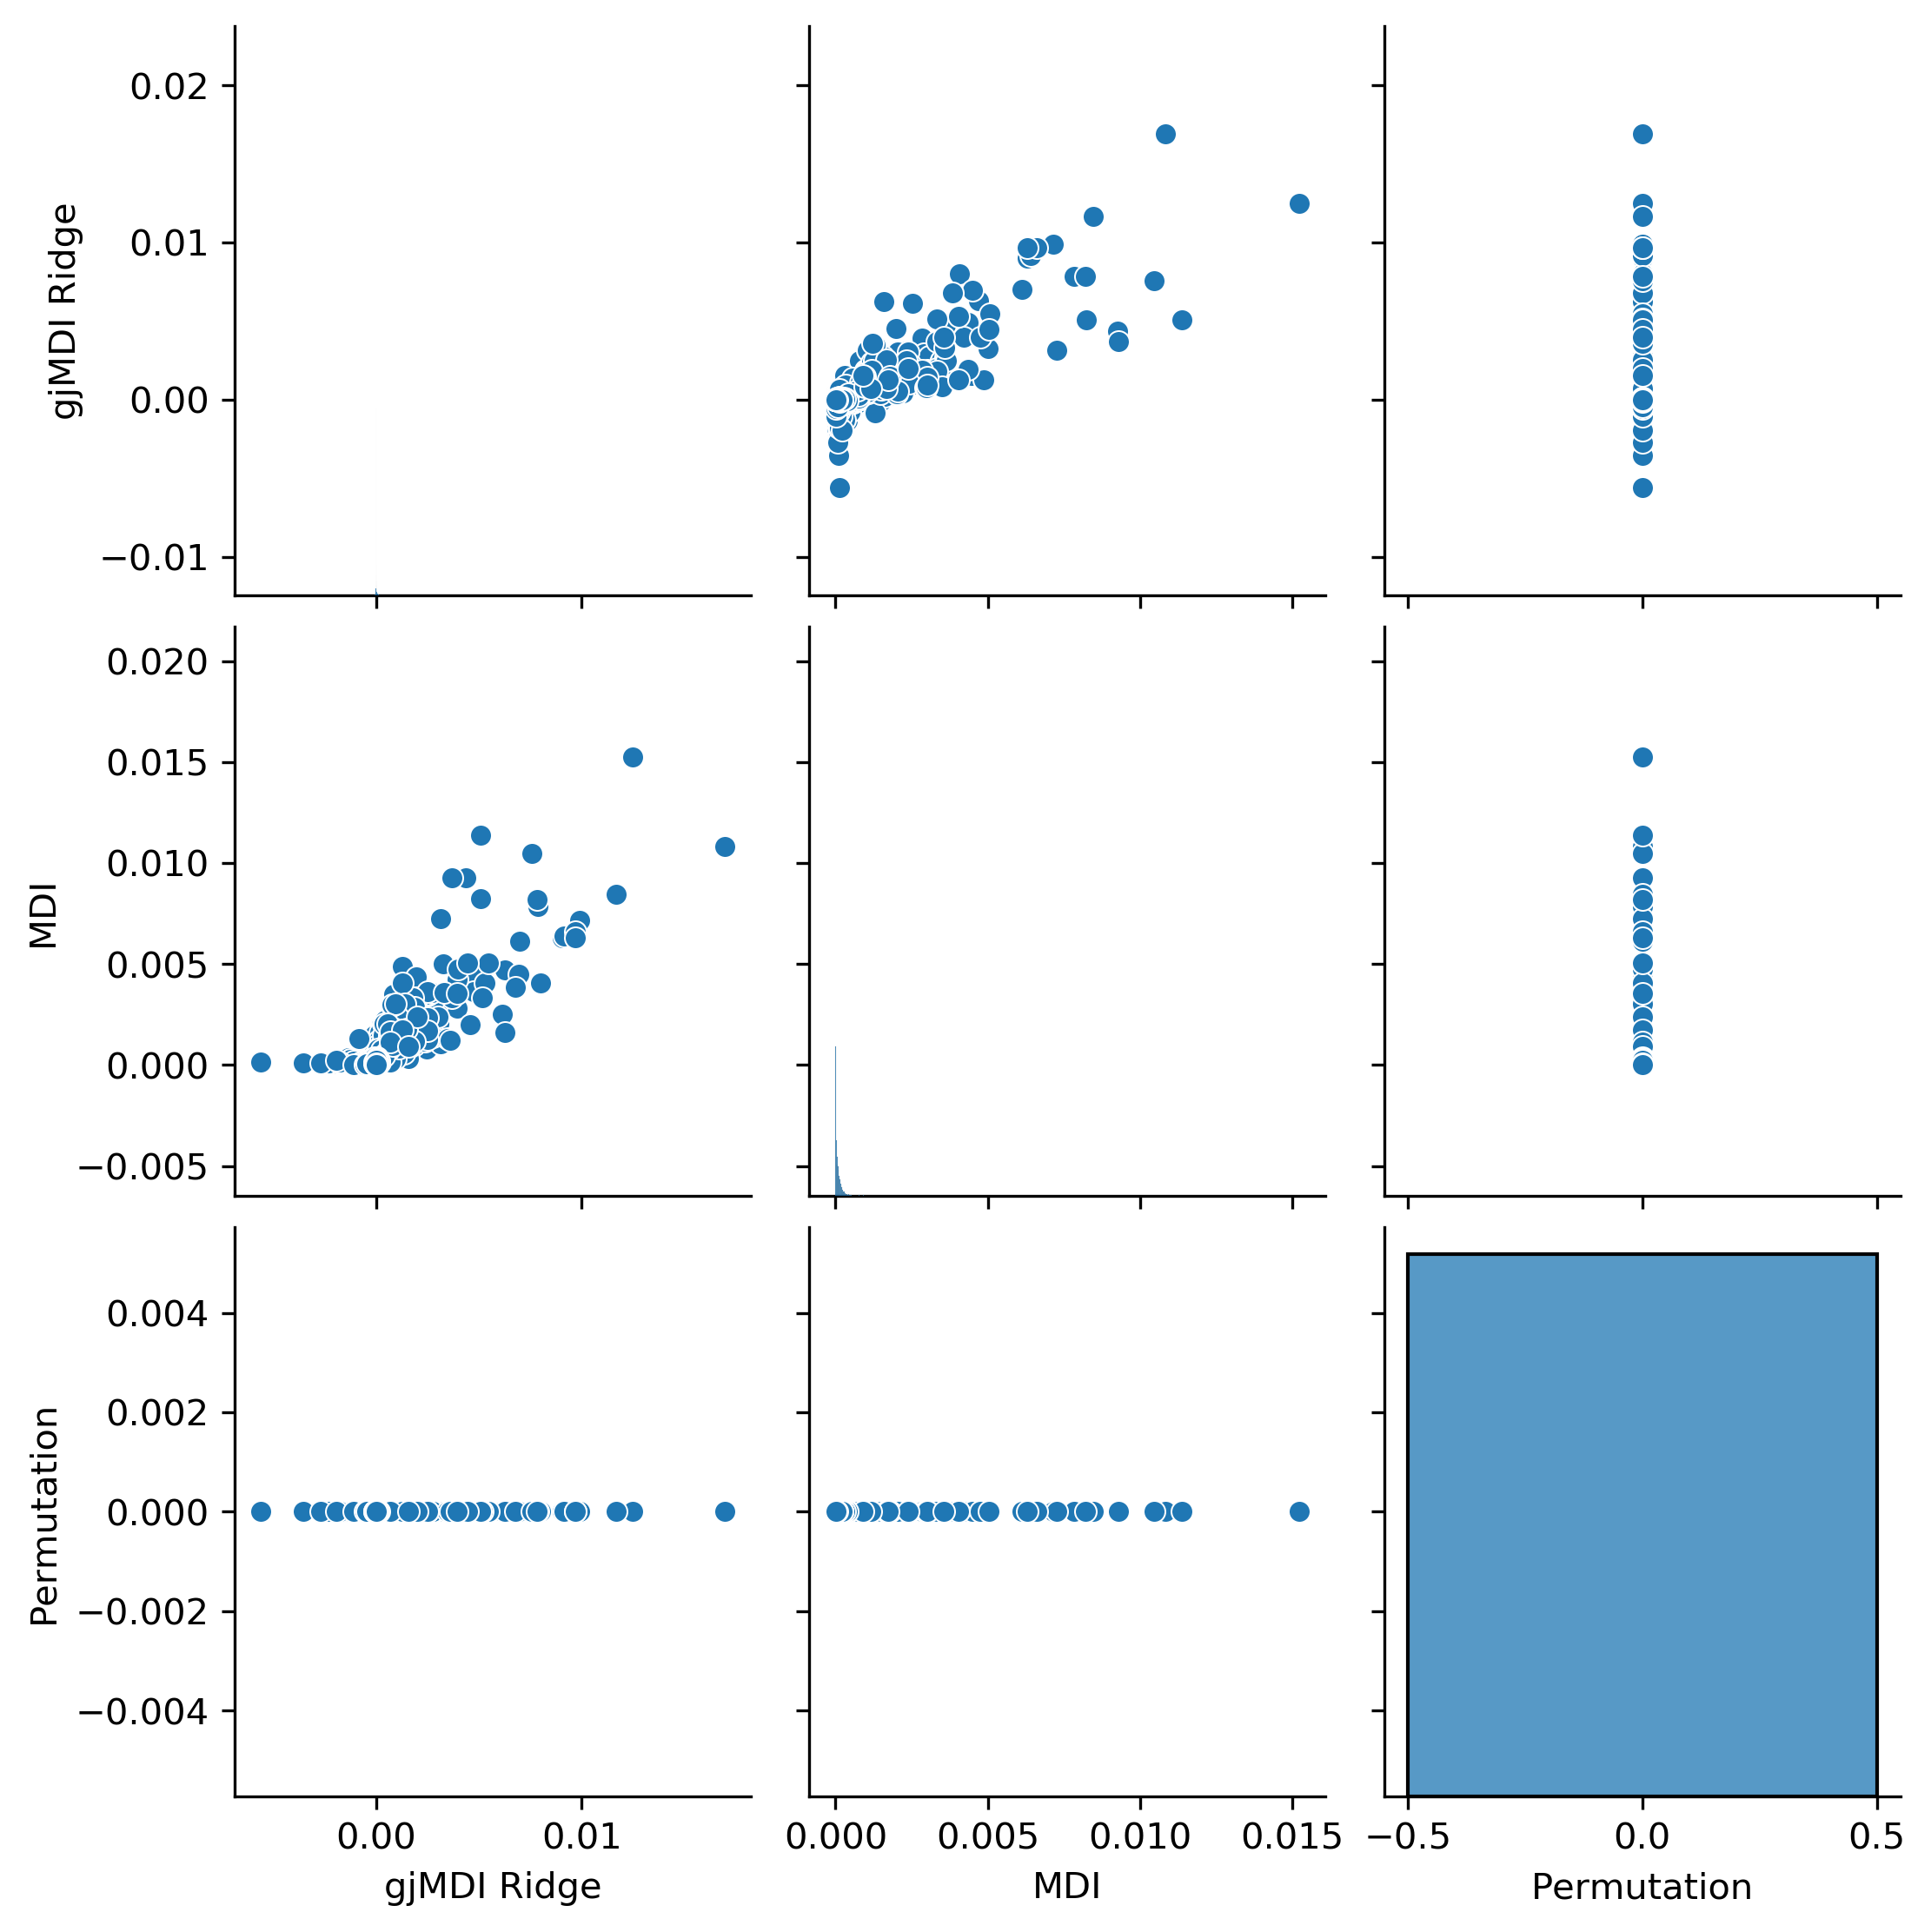

In [77]:
method_comparison_df = pd.DataFrame({"gjMDI Ridge": imp_values_df["rep0"],
                                     "MDI": mdi_imp_values_df["rep0"],
                                     "Permutation": perm_imp_values_df["rep0"]})
sns.pairplot(method_comparison_df)

In [78]:
perm_imp_values_df

rep0  rep1  rep2  rep3  rep4  rep5  rep6  rep7  rep8  rep9
0      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
1      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
2      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
3      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
4      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...
4995   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
4996   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
4997   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
4998   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
4999   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0

[5000 rows x 10 columns]

In [101]:
def isin_top_n(x, n=10):
    return x > x.sort_values(ascending=False).values[n]
gjmdi_top10 = pd.DataFrame({
    "feature": X_df.columns,
    "top10_prop": imp_values_df.apply(isin_top_n, axis=0).mean(axis=1)
})
mdi_top10 = pd.DataFrame({
    "feature": X_df.columns,
    "top10_prop": mdi_imp_values_df.apply(isin_top_n, axis=0).mean(axis=1)
})

In [103]:
gjmdi_top10 = gjmdi_top10[gjmdi_top10["top10_prop"] > 0]
mdi_top10 = mdi_top10[mdi_top10["top10_prop"] > 0]

In [106]:
gjmdi_top10.shape, mdi_top10.shape

((31, 2), (44, 2))

In [107]:
from plotnine import ggplot, aes, geom_bar

In [108]:
gjmdi_top10.head()

feature  top10_prop
235    CA12         0.1
296    CDK1         0.4
300    CDC6         0.1
301   CDC20         0.1
626    ESR1         1.0

[Text(0, 0, 'ESR1'),
 Text(0, 0, 'TPX2'),
 Text(0, 0, 'FOXM1'),
 Text(0, 0, 'GATA3'),
 Text(0, 0, 'MYBL2'),
 Text(0, 0, 'AGR3'),
 Text(0, 0, 'PLK1'),
 Text(0, 0, 'FOXA1'),
 Text(0, 0, 'KIF2C'),
 Text(0, 0, 'UBE2C'),
 Text(0, 0, 'CDK1'),
 Text(0, 0, 'SPAG5'),
 Text(0, 0, 'THSD4'),
 Text(0, 0, 'MAPT'),
 Text(0, 0, 'TBC1D9'),
 Text(0, 0, 'MLPH'),
 Text(0, 0, 'ANLN'),
 Text(0, 0, 'CA12'),
 Text(0, 0, 'PSAT1'),
 Text(0, 0, 'ZNF552'),
 Text(0, 0, 'DEGS2'),
 Text(0, 0, 'NUSAP1'),
 Text(0, 0, 'ANXA9'),
 Text(0, 0, 'RACGAP1'),
 Text(0, 0, 'XBP1'),
 Text(0, 0, 'RRM2'),
 Text(0, 0, 'KPNA2'),
 Text(0, 0, 'FOXC1'),
 Text(0, 0, 'CDC20'),
 Text(0, 0, 'CDC6'),
 Text(0, 0, 'ASPM')]

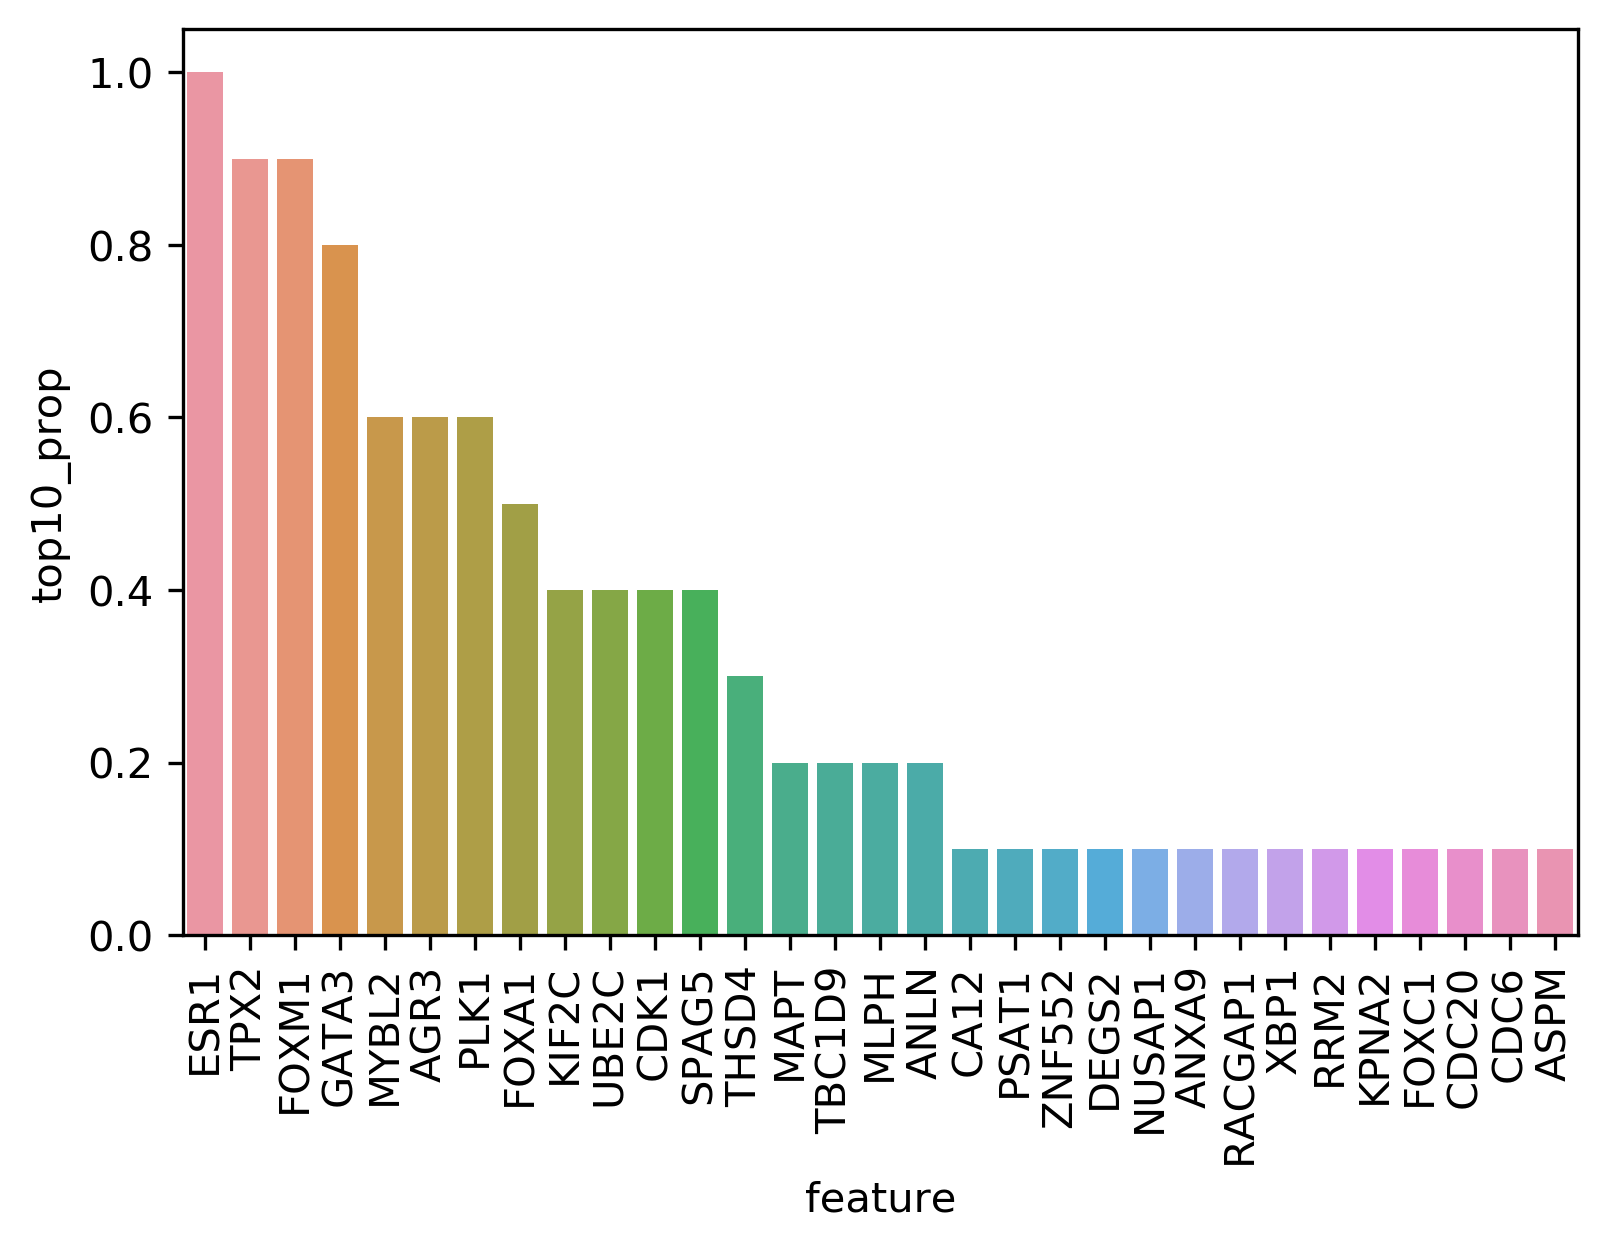

In [117]:
ax = sns.barplot(x="feature", y="top10_prop", data=gjmdi_top10,
                 order=gjmdi_top10.sort_values("top10_prop", ascending=False)["feature"])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

[Text(0, 0, 'TPX2'),
 Text(0, 0, 'ESR1'),
 Text(0, 0, 'FOXA1'),
 Text(0, 0, 'AGR2'),
 Text(0, 0, 'PLK1'),
 Text(0, 0, 'MLPH'),
 Text(0, 0, 'FOXC1'),
 Text(0, 0, 'FOXM1'),
 Text(0, 0, 'GATA3'),
 Text(0, 0, 'AGR3'),
 Text(0, 0, 'DEGS2'),
 Text(0, 0, 'THSD4'),
 Text(0, 0, 'PSAT1'),
 Text(0, 0, 'SPDEF'),
 Text(0, 0, 'TBC1D9'),
 Text(0, 0, 'XBP1'),
 Text(0, 0, 'CA12'),
 Text(0, 0, 'MYBL2'),
 Text(0, 0, 'PRR15'),
 Text(0, 0, 'GABRP'),
 Text(0, 0, 'KIF2C'),
 Text(0, 0, 'ZNF552'),
 Text(0, 0, 'ANXA9'),
 Text(0, 0, 'ANLN'),
 Text(0, 0, 'CDC20'),
 Text(0, 0, 'C1orf64'),
 Text(0, 0, 'CMBL'),
 Text(0, 0, 'CKS1B'),
 Text(0, 0, 'SLC44A4'),
 Text(0, 0, 'ERBB4'),
 Text(0, 0, 'FBP1'),
 Text(0, 0, 'CLSTN2'),
 Text(0, 0, 'BCAS1'),
 Text(0, 0, 'VGLL1'),
 Text(0, 0, 'PRC1'),
 Text(0, 0, 'RACGAP1'),
 Text(0, 0, 'IFRD1'),
 Text(0, 0, 'SLC7A8'),
 Text(0, 0, 'KIFC1'),
 Text(0, 0, 'KPNA2'),
 Text(0, 0, 'UBE2C'),
 Text(0, 0, 'CDK1'),
 Text(0, 0, 'TTLL4'),
 Text(0, 0, 'NUSAP1')]

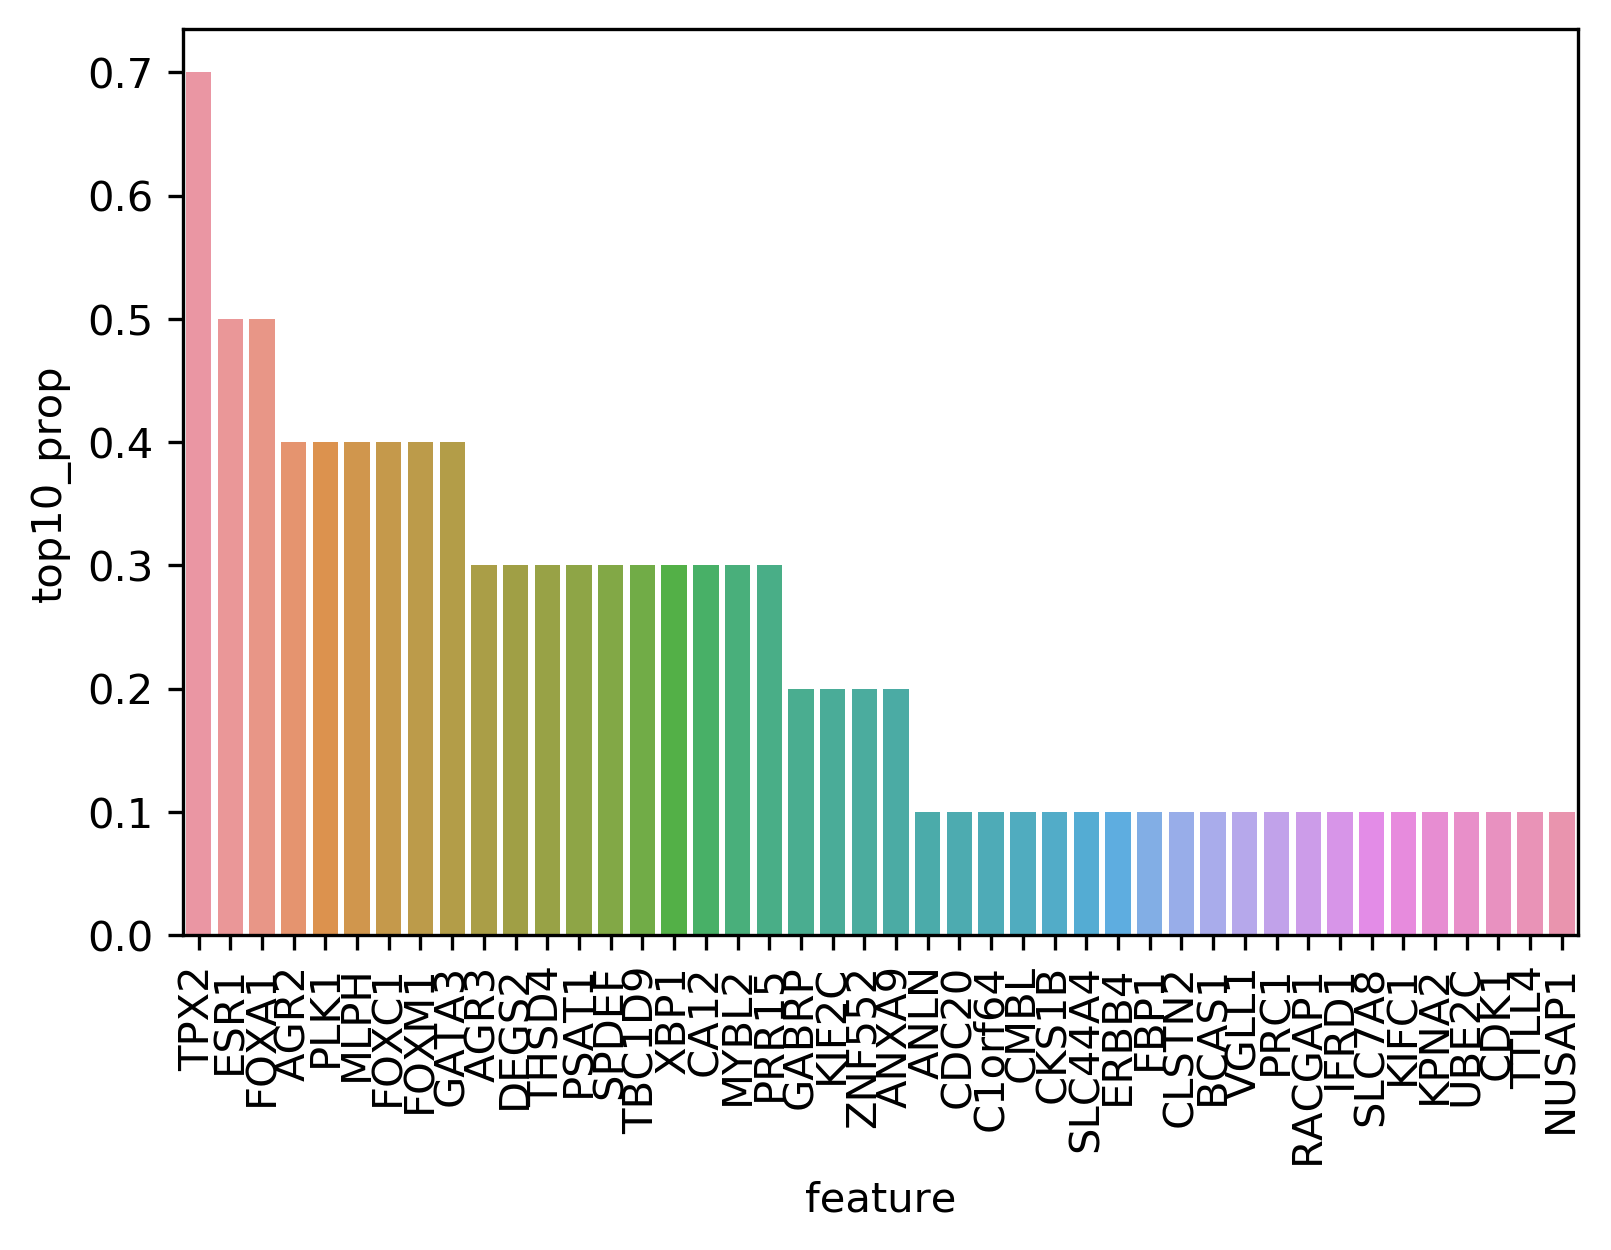

In [118]:
ax = sns.barplot(x="feature", y="top10_prop", data=mdi_top10,
                 order=mdi_top10.sort_values("top10_prop", ascending=False)["feature"])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

## Try gjMDI with different metric

In [137]:
import sklearn.metrics as metrics

In [138]:
def multiclass_f1_score(y_onehot, ypreds, sample_weight=None):
    ypreds_label = ypreds.argmax(axis=1)
    y_label = y_onehot.argmax(axis=1)
    results = np.zeros(ypreds.shape[1])
    for k in range(ypreds.shape[1]):
        ypreds_k = (ypreds_label == k).astype(int)
        y_k = (y_label == k).astype(int)
        results[k] = metrics.f1_score(y_k, ypreds_k)
    return results

In [139]:
N_REPS = 10
METRIC = multiclass_f1_score

In [140]:
imp_values_dict2 = {}
class_scores_dict2 = {}
for rep in tqdm(range(N_REPS)):
    rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_features="sqrt",
                                      random_state=rep)
    scorer = JointRidgeScorer(criterion="gcv", metric=METRIC)
    gjMDI_obj = GeneralizedMDIJoint(rf_model, scorer=scorer, normalize_raw=True, random_state=331)
    imp_values, _, class_scores, _, _ = gjMDI_obj.get_importance_scores(X, y, diagnostics=True)
    imp_values_dict2[rep] = copy.deepcopy(imp_values)
    class_scores_dict2[rep] = copy.deepcopy(class_scores.drop("tree", axis=1).
                                            groupby("feature").agg("mean").reset_index())


100%|██████████| 10/10 [17:57<00:00, 107.73s/it]


In [141]:
imp_values_df2 = pd.DataFrame.from_dict(imp_values_dict2)
imp_values_df2.columns = ["rep{}".format(i) for i in range(imp_values_df2.shape[1])]


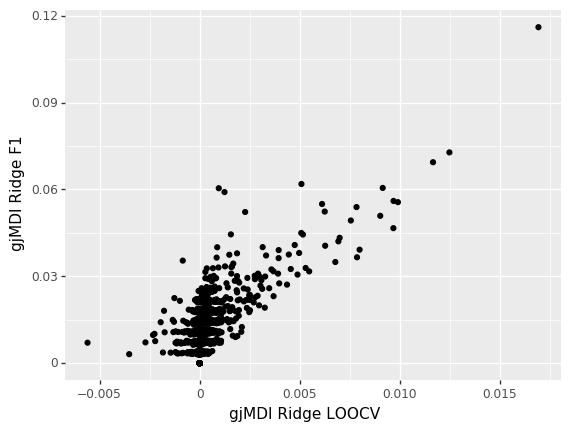

<ggplot: (8780917248133)>

In [142]:
method_comparison_df = pd.DataFrame({"gjMDI Ridge LOOCV": imp_values_df["rep0"],
                                     "gjMDI Ridge F1": imp_values_df2["rep0"],
                                     "feature": X_df.columns})
ggplot(method_comparison_df) +\
    aes(x="gjMDI Ridge LOOCV", y="gjMDI Ridge F1") +\
    geom_point()

In [143]:
method_comparison_df.sort_values("gjMDI Ridge F1", ascending=False)

gjMDI Ridge LOOCV  gjMDI Ridge F1 feature
626            0.016941        0.116043    ESR1
885            0.012489        0.072814   FOXA1
3114           0.011669        0.069414    TPX2
686            0.005091        0.061899   FOXC1
2873           0.009156        0.060542   SPAG5
...                 ...             ...     ...
2489           0.000000        0.000000   ITM2B
4111           0.000000        0.000000   TAOK1
2491           0.000000        0.000000  MAP4K4
2504           0.000000        0.000000  XAGE1B
2500           0.000000        0.000000   PSMF1

[5000 rows x 3 columns]

In [144]:
gjmdi2_top10 = pd.DataFrame({
    "feature": X_df.columns,
    "top10_prop": imp_values_df2.apply(isin_top_n, axis=0).mean(axis=1)
})
gjmdi2_top10 = gjmdi2_top10[gjmdi2_top10["top10_prop"] > 0]

In [145]:
gjmdi2_top10.shape

(39, 2)

[Text(0, 0, 'ESR1'),
 Text(0, 0, 'TPX2'),
 Text(0, 0, 'FOXC1'),
 Text(0, 0, 'GATA3'),
 Text(0, 0, 'FOXA1'),
 Text(0, 0, 'FOXM1'),
 Text(0, 0, 'SFRP1'),
 Text(0, 0, 'CDK1'),
 Text(0, 0, 'KRT14'),
 Text(0, 0, 'MIA'),
 Text(0, 0, 'SOX10'),
 Text(0, 0, 'RRM2'),
 Text(0, 0, 'NUSAP1'),
 Text(0, 0, 'SPAG5'),
 Text(0, 0, 'GABRP'),
 Text(0, 0, 'TBC1D9'),
 Text(0, 0, 'ZNF552'),
 Text(0, 0, 'FAM171A1'),
 Text(0, 0, 'MLPH'),
 Text(0, 0, 'FAM63A'),
 Text(0, 0, 'ANLN'),
 Text(0, 0, 'UBE2C'),
 Text(0, 0, 'THSD4'),
 Text(0, 0, 'AGR3'),
 Text(0, 0, 'ZWINT'),
 Text(0, 0, 'BCL2'),
 Text(0, 0, 'KIF2C'),
 Text(0, 0, 'PRC1'),
 Text(0, 0, 'TIMELESS'),
 Text(0, 0, 'PLK1'),
 Text(0, 0, 'MYBL2'),
 Text(0, 0, 'MKI67'),
 Text(0, 0, 'KRT17'),
 Text(0, 0, 'KRT5'),
 Text(0, 0, 'KIF11'),
 Text(0, 0, 'COL17A1'),
 Text(0, 0, 'CENPF'),
 Text(0, 0, 'CDC6'),
 Text(0, 0, 'ASPM')]

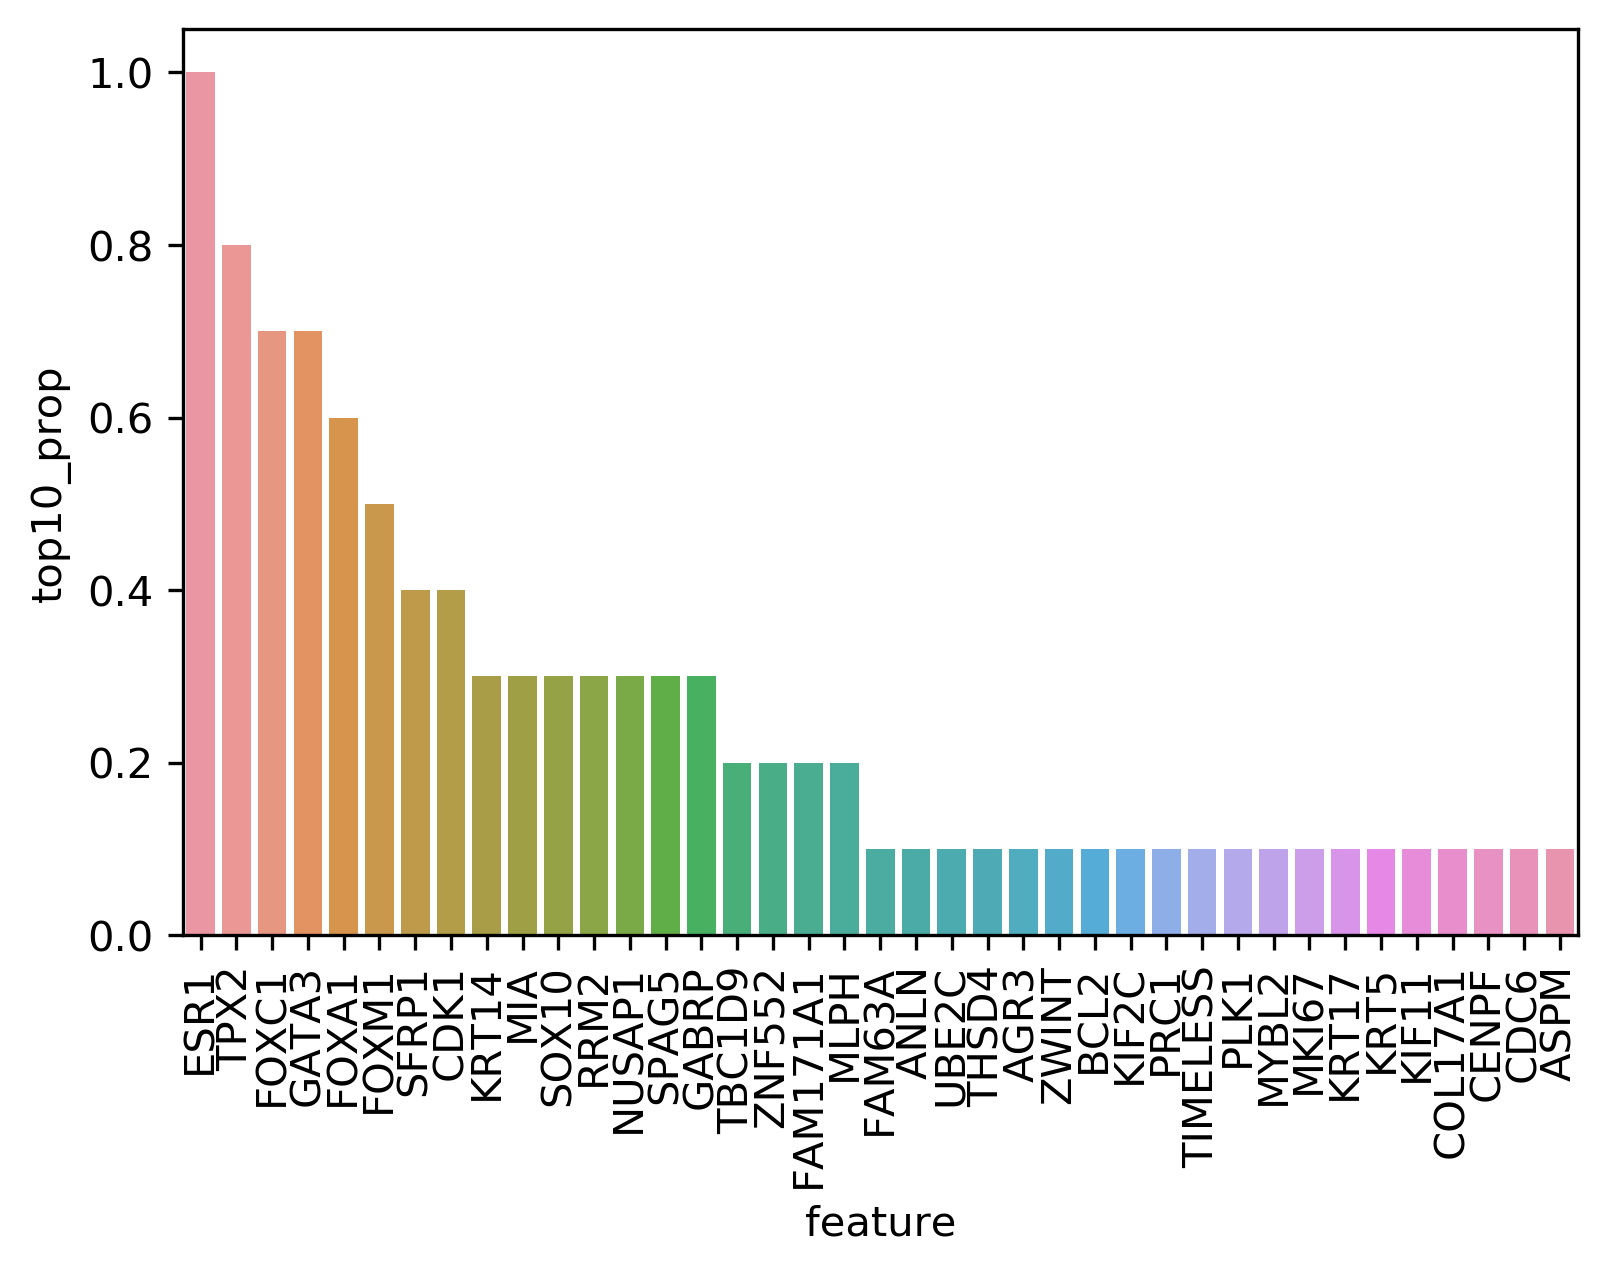

In [146]:
ax = sns.barplot(x="feature", y="top10_prop", data=gjmdi2_top10,
                 order=gjmdi2_top10.sort_values("top10_prop", ascending=False)["feature"])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

In [150]:
len(np.intersect1d(gjmdi_top10["feature"], gjmdi2_top10["feature"]))

22

In [151]:
np.intersect1d(gjmdi_top10["feature"], gjmdi2_top10["feature"])

array(['AGR3', 'ANLN', 'ASPM', 'CDC6', 'CDK1', 'ESR1', 'FOXA1', 'FOXC1',
       'FOXM1', 'GATA3', 'KIF2C', 'MLPH', 'MYBL2', 'NUSAP1', 'PLK1',
       'RRM2', 'SPAG5', 'TBC1D9', 'THSD4', 'TPX2', 'UBE2C', 'ZNF552'],
      dtype=object)

## TreeSHAP

In [33]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X)
shap_values
# results = abs(shap_values)
# results = results.mean(axis=0)

[array([[ 3.16174679e-06, -2.74692621e-03,  9.28960353e-05, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.15930716e-05, -1.13244270e-03,  4.74957173e-05, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-2.11362703e-05, -9.63393690e-04,  5.53187835e-05, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 2.28530572e-06, -1.26429179e-03,  6.08020185e-05, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.15930716e-05, -1.03765433e-03,  1.99174636e-06, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 2.09019333e-05, -2.46904165e-03,  4.72206470e-05, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]),
 array([[-1.54514781e-05, -5.84947150e-04, -5.20077443e-04, ...,
          0.00000000e+00, -5.13663308e-05,  0.00000000e+00],
        [ 6.45471991e-05, -2.46507495e-04, -1.96589508e-04, ...,
          0.00000000e+00, -1.85695556e

AttributeError: 'list' object has no attribute 'shape'